In [1]:
import numpy as np
import random
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.linalg import sqrtm
from skimage.transform import resize
import cv2
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.layers import Activation, Dense, Input, Dropout, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape, Concatenate, Lambda, Layer
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras import metrics
from keras.applications.inception_v3 import preprocess_input, InceptionV3
import keras.backend as K

Using TensorFlow backend.


In [2]:
## Constants
OLD_IMAGE_DIMS = (218, 178, 3)
NEW_IMAGE_DIMS = (64, 64, 3)
BATCH_SIZE = 64
N = 100
NUM_ATTRIBUTES = 40
NUM_BATCHES = 2
LATENT_DIM = 64
TOT_IMAGES = 202599
EPOCHS = 1

In [3]:
## Constants defining path to dataset
PATH = './'
IMAGES = 'img_align_celeba/'
ATTRIBUTES = 'list_attr_celeba.txt'

In [38]:
## Loading dataset
def get_attributes(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    attributes = []
    attr = []
    i = 0
    for line in lines:
        if i != 0 and i != 1:
            line = line.split()
            attributes.append(line)
        i += 1
    #for i in range(len(attributes)):
        #for j in range(len(attributes[i])):
            #if attributes[i][j] == '-1':
                #attributes[i][j] = '0'
    #f.close()
    return attributes

def get_attribute_names(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    return lines[1].split()

def initialize_training_set(): 
    all_attributes = get_attributes(PATH + ATTRIBUTES)
    
    while True:
        chosen_info = random.sample(all_attributes, BATCH_SIZE)#N)
        chosen_attributes = [info[1:] for info in chosen_info]
        chosen_images = [info[0] for info in chosen_info]
        resized_images = []
    
        for ind in range(len(chosen_info)):
            image_path = PATH + IMAGES + chosen_images[ind]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[...,::-1] / 255.0
            img = img[45:173,25:153]
            img = cv2.resize(src=img, dsize=(64, 64))
            resized_images.append(img)

        resized_images = np.array(resized_images, dtype=np.float32)
        chosen_attributes = np.array(chosen_attributes, dtype=np.float32)

        yield [resized_images, chosen_attributes], None 
        
def initialize_test_set():
    all_attributes = get_attributes(PATH + ATTRIBUTES)
    info_in_batches = []
    attributes_in_batches = []
    images_in_batches = []
    test_set = []
    
    for i in range(NUM_BATCHES):
        chosen_info = random.sample(all_attributes, BATCH_SIZE)
        chosen_attributes = [info[1:] for info in chosen_info]
        chosen_images = [info[0] for info in chosen_info]
        
        info_in_batches.append(chosen_info)
        attributes_in_batches.append(chosen_attributes)
        images_in_batches.append(chosen_images)
        
    for i in range(NUM_BATCHES):
        chosen_images = images_in_batches[i]
        attributes = attributes_in_batches[i]
        resized_images = []
        
        for j in range(BATCH_SIZE):
            image_path = PATH + IMAGES + chosen_images[j]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)[...,::-1] / 255.0
            img = img[45:173,25:153]
            img = cv2.resize(src=img, dsize=(64, 64))
            resized_images.append(img)

        resized_images = np.array(resized_images, dtype=np.float32)
        attributes = np.array(chosen_attributes, dtype=np.float32)

        test_set.append([resized_images, attributes])
        #yield [resized_images, attributes]
    return test_set

training_set = initialize_training_set()
test_set = initialize_test_set()

print(test_set)

[[array([[[[0.8931373 , 0.81666666, 0.8147059 ],
         [0.83235294, 0.74019605, 0.7362745 ],
         [0.7245098 , 0.6186274 , 0.61470586],
         ...,
         [0.9362745 , 0.8833333 , 0.827451  ],
         [0.9362745 , 0.88529414, 0.84313726],
         [0.9254902 , 0.8745098 , 0.82058823]],

        [[0.9382353 , 0.8598039 , 0.8598039 ],
         [0.8754902 , 0.7921569 , 0.78039217],
         [0.6127451 , 0.5245098 , 0.5107843 ],
         ...,
         [0.9617647 , 0.9137255 , 0.8931373 ],
         [0.9607843 , 0.90686274, 0.9098039 ],
         [0.93921566, 0.88529414, 0.85294116]],

        [[0.922549  , 0.84411764, 0.8401961 ],
         [0.79607844, 0.72156864, 0.7019608 ],
         [0.3617647 , 0.29117647, 0.2637255 ],
         ...,
         [0.95980394, 0.9117647 , 0.89509803],
         [0.95490193, 0.9009804 , 0.90686274],
         [0.9284314 , 0.86960787, 0.8245098 ]],

        ...,

        [[0.85784316, 0.6362745 , 0.55784315],
         [0.8009804 , 0.6764706 , 0.6166667

In [5]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def VAE():
    #Define encoder model.
    input_img = Input(shape = NEW_IMAGE_DIMS, name='input_img')
    attributes= Input(shape = (NUM_ATTRIBUTES,), name='attributes')

    x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(input_img)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 512, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)

    shape_before_flattening = K.int_shape(x)[1:]

    x = Flatten()(x)

    z_mean = Dense(LATENT_DIM, name='z_mean')(x)
    z_log_sigma = Dense(LATENT_DIM, name='z_log_sigma')(x)
    z = Sampling()([z_mean, z_log_sigma])

    zy = Concatenate()([z, attributes])

    inputs_embedding = Input(shape=(LATENT_DIM + NUM_ATTRIBUTES,))
    embedding = Dense(np.prod(shape_before_flattening))(inputs_embedding)
    embedding = Reshape(shape_before_flattening)(embedding)

    #Decoding
    x_ = Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(embedding)
    x_ = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
    x_ = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
    x_ = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu')(x_)
    x_ = Conv2DTranspose(filters = 3, kernel_size = 3, strides = 2,  padding = 'same', activation = 'sigmoid')(x_)

    encoder = Model(inputs = [input_img, attributes], outputs = zy, name="encoder")
    decoder = Model(inputs = inputs_embedding, outputs = x_, name="decoder")

    vae_out = decoder(encoder([input_img, attributes]))

    rec_loss =  np.prod(NEW_IMAGE_DIMS) * binary_crossentropy(Flatten()(input_img), Flatten()(vae_out))
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    vae_loss = K.mean(rec_loss + kl_loss)

    vae = Model(inputs = [input_img, attributes], outputs = vae_out, name="vae")

    vae.add_loss(vae_loss)

    optimizer = Adam(lr=0.0005, beta_1 = 0.5)
    vae.compile(optimizer)

    return vae, encoder, decoder

vae, encoder, decoder = VAE()

encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_img[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 8, 8, 128)    73856       conv2d_2[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [6]:
vae.fit(training_set, steps_per_epoch = N//BATCH_SIZE, verbose = 1, epochs = EPOCHS)

Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 8517.6543


In [22]:
# Save model weights
vae.save_weights('./vae.h5')
decoder.save_weights('./decoder.h5')
encoder.save_weights('./encoder.h5')

In [6]:
# Load model weights
vae.load_weights('./vae.h5')
decoder.load_weights('./decoder.h5')
encoder.load_weights('./encoder.h5')

In [7]:
# Calculate Frechet Inception Distance (https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/)

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [8]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg')#, input_shape=(299,299,3))

In [39]:
def reconstruct_images(test_set):
    print('Reconstructing images')
    images_for_fid = []
    predictions_for_fid = []
    
    img_act = np.array([]).reshape((0, 2048))
    pred_act = np.array([]).reshape((0, 2048))
    
    index = 1
    
    for batch in test_set:
        print('Batch:', index)
        example_images = batch[0] * 255.0
        example_predictions = vae.predict(batch) * 255.0
        
        # Scaling images
        scaled_images = scale_images(example_images, (299, 299, 3))
        scaled_predictions = scale_images(example_predictions, (299, 299, 3))
        
        # Pre-processing images
        preprocessed_images = preprocess_input(scaled_images)
        preprocessed_predictions = preprocess_input(scaled_predictions)
        
        act1 = model.predict(preprocessed_images)
        act2 = model.predict(preprocessed_predictions)
        
        images_for_fid.append(act1)
        predictions_for_fid.append(act2)
        
        img_act = np.concatenate((img_act, act1), axis = 0)
        pred_act = np.concatenate((pred_act, act2), axis = 0)
                      
        index += 1

    return example_images, example_predictions, images_for_fid, predictions_for_fid


def generate_images(generated_attributes):
    print('')
    print('Generating images')
    
    predictions_for_fid = []
    
    #images = np.random.uniform(-1, 1, size = (NUM_BATCHES * BATCH_SIZE, LATENT_DIM)).astype(np.float32)
    images = np.random.uniform(0, 1, size = (NUM_BATCHES * BATCH_SIZE, LATENT_DIM)).astype(np.float32)
    
    for i in range(NUM_BATCHES):
        print('Batch:', i+1)
        batch = []
        
        for j in range(BATCH_SIZE):
            img_info = []
            img_info.append(np.concatenate((images[j].flatten(), generated_attributes)))
            batch.append(np.array(img_info).flatten())
            
        batch = np.array(batch)
        predictions = decoder.predict(batch)
        
        # Scaling images
        scaled_predictions = scale_images(predictions, (299, 299, 3))
        
        # Pre-processing images
        preprocessed_predictions = preprocess_input(scaled_predictions)
        
        predictions_for_fid.append(preprocessed_predictions)

    return predictions, predictions_for_fid


In [35]:
# Showing possible attributes
attributes = get_attribute_names(PATH + ATTRIBUTES)

for i in range(len(attributes)):
    print(i, attributes[i])

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


In [40]:
# Reconstructing images with VAE
rec_images, rec_predictions, images_for_fid, rec_predictions_for_fid = reconstruct_images(test_set) 

print(len(np.array(images_for_fid).flatten()))

Reconstructing images
Batch: 1
Batch: 2
262144


In [41]:
print(np.array(images_for_fid))#.reshape((64,2048)))
print(np.array(images_for_fid).shape)

[[[4.41788316e-01 3.98450494e-01 6.03184886e-02 ... 7.32461631e-01
   5.19302376e-02 2.39245415e-01]
  [7.10415393e-02 1.21345058e-01 7.23623019e-03 ... 9.21642482e-01
   2.21408606e-01 6.93601191e-01]
  [3.23013663e-01 4.19845372e-01 4.15473208e-02 ... 8.72579336e-01
   1.64577588e-01 4.93323058e-01]
  ...
  [2.48039618e-01 1.01062566e-01 5.40169626e-02 ... 3.55679274e-01
   9.37497243e-04 0.00000000e+00]
  [1.20546594e-01 2.89089084e-01 2.22856328e-02 ... 9.45528388e-01
   1.05078770e-02 2.93496847e-01]
  [2.45532006e-01 7.23672360e-02 1.05116796e-02 ... 5.04663110e-01
   4.75773215e-01 1.07247281e+00]]

 [[5.20967171e-02 6.74530089e-01 1.02400832e-01 ... 1.27593410e+00
   4.24239784e-01 9.77374539e-02]
  [1.62585557e-01 1.56777203e-01 8.78578797e-02 ... 1.12605333e+00
   4.08979267e-01 5.86769640e-01]
  [1.91117972e-01 2.13149920e-01 0.00000000e+00 ... 9.08142924e-01
   2.82058865e-02 4.03441228e-02]
  ...
  [3.91007960e-01 1.30994156e-01 1.38995275e-01 ... 4.70805287e-01
   2.27736

In [27]:
chosen_attributes = np.zeros(NUM_ATTRIBUTES, dtype=np.float32)

#chosen_attributes[8] = 1   # black hair
#chosen_attributes[19] = 1  # male
#chosen_attributes[31] = 1  # smiling

chosen_attributes[4] = 1  # bald
chosen_attributes[22] = 1 # mustache


# Generating new images with VAE
gen_predictions, gen_predictions_for_fid = generate_images(chosen_attributes)


Generating images
Batch: 1


In [28]:
def show_images(batch, name):
    used_indices = []
    nrow = 2
    ncol = 8
    fig = plt.figure(figsize=((ncol+1)*1.5, (nrow+1)*1.5)) 
    gs = mpl.gridspec.GridSpec(nrow, ncol,
             wspace=0.0, hspace=0.0, 
             top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
             left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 
    for i in range(16):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(batch[i])
        plt.axis('off')
    plt.show()
    #plt.savefig(name)

In [42]:
print('Original images')
show_images(rec_images, 'rec_images')
print('\n')
print('Reconstructed images')
show_images(rec_predictions, 'rec_predictions')

Original images


NameError: name 'show_images' is not defined

In [43]:
#fid_score = calculate_fid(np.array(images_for_fid).reshape((64,2048)), np.array(rec_predictions_for_fid).reshape((64,2048)))
#print(images_for_fid.shape)
fid_score = calculate_fid(np.array(images_for_fid[-1]), np.array(rec_predictions_for_fid[-1]))
print('FID for reconstructed images:', fid_score)

FID for reconstructed images: 503.00424155217354


Generated images


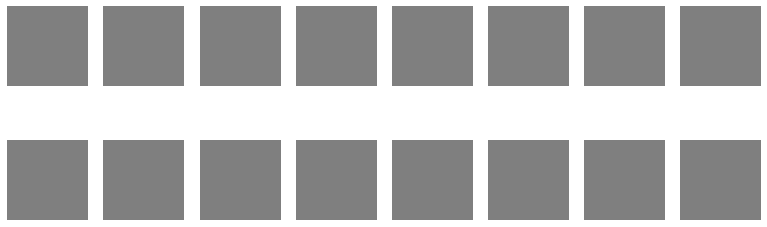

In [31]:
print('Generated images')
show_images(gen_predictions, 'gen_predictions')

In [33]:
fid_score = calculate_fid(images_for_fid, gen_predictions_for_fid)
print('FID for reconstructed images:', fid_score)

AttributeError: 'list' object has no attribute 'mean'